In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os 
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator

## START

In [ ]:
train_gen=ImageDataGenerator(rescale=1/255.0,shear_range=0.2,zoom_range=0.2,horizontal_flip=True)
train_data=train_gen.flow_from_directory('/content/drive/MyDrive/Alzheimer Datasets/A4 Classes/Alzheimer_s Dataset/train', 
                                        target_size= (128, 128),
                                       class_mode = 'categorical', 
                                       batch_size = 32, 
                                       shuffle = True,
                                       subset='training')
test_data=train_gen.flow_from_directory('/content/drive/MyDrive/Alzheimer Datasets/A4 Classes/Alzheimer_s Dataset/test', 
                                        target_size= (128, 128),
                                        class_mode = 'categorical', 
                                        batch_size = 32, 
                                        shuffle = True)


Found 5121 images belonging to 4 classes.
Found 1279 images belonging to 4 classes.


## Or

In [ ]:
os.listdir(f'/content/drive/MyDrive/Alzheimer Datasets/A4 Classes/Alzheimer_s Dataset/train')

['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

In [ ]:
from sklearn.utils import shuffle
DATA=[]
for folder in os.listdir('/content/drive/MyDrive/Alzheimer Datasets/A4 Classes/Alzheimer_s Dataset/train'):
  print(folder)
  for image in os.listdir(f'/content/drive/MyDrive/Alzheimer Datasets/A4 Classes/Alzheimer_s Dataset/train/{folder}')[:2]:
    DATA.append((folder))
DATA=np.array((DATA))
DATA

MildDemented
ModerateDemented
NonDemented
VeryMildDemented


array(['MildDemented', 'MildDemented', 'ModerateDemented',
       'ModerateDemented', 'NonDemented', 'NonDemented',
       'VeryMildDemented', 'VeryMildDemented'], dtype='<U16')

In [ ]:
from sklearn.utils import shuffle
DATA=[]
for main_ in ['train', 'test']:
  for i,folder in enumerate(os.listdir(f'/content/drive/MyDrive/Alzheimer Datasets/A4 Classes/Alzheimer_s Dataset/{main_}')):
    for image in os.listdir(f'/content/drive/MyDrive/Alzheimer Datasets/A4 Classes/Alzheimer_s Dataset/{main_}/{folder}'):
      img=cv2.imread(f'/content/drive/MyDrive/Alzheimer Datasets/A4 Classes/Alzheimer_s Dataset/{main_}/{folder}/{image}')
      img=cv2.resize(img,(128,128))/255.0
      DATA.append((img,i))
DATA=np.array(shuffle(DATA))

<ipython-input-3-feccfdeadbf8>:9: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  DATA=np.array(shuffle(DATA))


In [ ]:
Images=np.array([i for i in DATA[:,0]]).reshape((6400,128,128,3))
Labels=DATA[:,1].astype(np.float32)

In [ ]:
x_train,x_test,y_train,y_test=Images[:5600],Images[5600:],Labels[:5600],Labels[5600:]
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((5600, 128, 128, 3), (800, 128, 128, 3), (5600,), (800,))

In [ ]:
from keras.utils import to_categorical
y_train=to_categorical(y_train,4)
y_test=to_categorical(y_test,4)
y_train.shape

(5600, 4)

## Compact Convolutional Vision Transformer

## Loading Data

In [ ]:
positional_emb = True
conv_layers = 4
projection_dim = 128
input_shape=(128,128,3)
image_size = 128
patch_size = 8  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
num_classes=4
num_heads = 4
transformer_units = [projection_dim,projection_dim]
transformer_layers = 2
stochastic_depth_rate = 0.1

learning_rate = 0.001
weight_decay = 0.0001
batch_size = 32
num_epochs = 30
from sklearn.utils import shuffle
from keras import layers


In [ ]:
class CCTTokenizer(layers.Layer):
    def __init__(self,kernel_size=3,stride=1,padding=1,pooling_kernel_size=3,pooling_stride=2,num_conv_layers=conv_layers,
        num_output_channels=[16, 128, 32, 128],positional_emb=positional_emb,**kwargs,):
      super(CCTTokenizer, self).__init__(**kwargs)
      self.conv_model = keras.Sequential()
      for i in range(num_conv_layers):
          self.conv_model.add(layers.Conv2D(
                    num_output_channels[i],
                    kernel_size,
                    stride,
                    padding="valid",
                    use_bias=False,
                    activation="relu",
                    kernel_initializer="he_normal",
                ))
          self.conv_model.add(layers.ZeroPadding2D(padding))
          self.conv_model.add(layers.MaxPool2D(pooling_kernel_size, pooling_stride, "same"))
      self.positional_emb = positional_emb
    def call(self, images):
        outputs = self.conv_model(images)
        reshaped = tf.reshape(
            outputs,  (-1, tf.shape(outputs)[1] * tf.shape(outputs)[2], tf.shape(outputs)[-1]))
        return reshaped
    def positional_embedding(self, image_size):
        if self.positional_emb:
            dummy_inputs = tf.ones((1, image_size, image_size, 3))
            dummy_outputs = self.call(dummy_inputs)
            sequence_length = tf.shape(dummy_outputs)[1]
            projection_dim = tf.shape(dummy_outputs)[-1]

            embed_layer = layers.Embedding(
                input_dim=sequence_length, output_dim=projection_dim
            )
            return embed_layer, sequence_length
        else:
            return None

In [ ]:
class StochasticDepth(layers.Layer):
    def __init__(self, drop_prop, **kwargs):
        super(StochasticDepth, self).__init__(**kwargs)
        self.drop_prob = drop_prop
    def call(self, x, training=None):
        if training:
            keep_prob = 1 - self.drop_prob
            shape = (tf.shape(x)[0],) + (1,) * (tf.shape(x).shape[0] - 1)
            random_tensor = keep_prob + tf.random.uniform(shape, 0, 1)
            random_tensor = tf.floor(random_tensor)
            return (x / keep_prob) * random_tensor
        return x

def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

data_augmentation = keras.Sequential(
    [layers.RandomCrop(image_size, image_size),layers.RandomFlip("horizontal")],
    name="data_augmentation"
                    )

In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches


class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) 
        return encoded

Image size: 128 X 128
Patch size: 8 X 8
Patches per image: 256
Elements per patch: 192


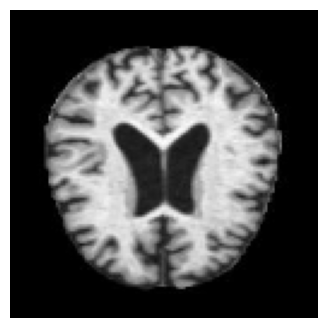

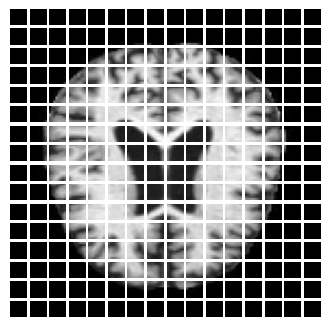

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4, 4))
image = x_train[np.random.choice(range(x_train.shape[0]))]
plt.imshow(image)
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy())
    plt.axis("off")

In [ ]:
def create_cct_model(
    image_size=image_size,
    input_shape=input_shape,
    num_heads=num_heads,
    projection_dim=projection_dim,
    transformer_units=transformer_units,
):

    inputs = layers.Input(input_shape)

    # Augment data.
    # augmented = data_augmentation(inputs)

    # Encode patches.
    cct_tokenizer = CCTTokenizer()
    cct_encoded_patches = cct_tokenizer(inputs)

    patches = Patches(patch_size)(inputs)
    # Encode patches.
    default_encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)
    
    # Apply positional embedding.
    if positional_emb:
        pos_embed, seq_length = cct_tokenizer.positional_embedding(image_size)
        positions = tf.range(start=0, limit=seq_length, delta=1)
        position_embeddings = pos_embed(positions)
        cct_encoded_patches += position_embeddings

    # Calculate Stochastic Depth probabilities.
    dpr = [x for x in np.linspace(0, stochastic_depth_rate, transformer_layers)]

    # Create multiple layers of the Transformer block.
    for i in range(transformer_layers):
        # Layer normalization 1.
        x1_c = layers.LayerNormalization(epsilon=1e-5)(cct_encoded_patches)
        x1_d = layers.LayerNormalization(epsilon=1e-5)(default_encoded_patches)
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=0.1)(x1_c, x1_d)
        attention_output_ = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=0.1)(x1_d, x1_c)
        # Global Attension Fusion
        # Skip connection 1.
        attention_output = StochasticDepth(dpr[i])(attention_output)
        x2_c = layers.concatenate([attention_output, cct_encoded_patches])
        x2_d = layers.concatenate([attention_output_, default_encoded_patches])
        # print(x2_G)
        # Layer normalization 2.
        x3_c = layers.LayerNormalization(epsilon=1e-5)(x2_c)
        x3_d = layers.LayerNormalization(epsilon=1e-5)(x2_d)
        # MLP.
        x3_c = mlp(x3_c, hidden_units=transformer_units, dropout_rate=0.1)
        x3_d = mlp(x3_d, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        x3_c = StochasticDepth(dpr[i])(x3_c)
        cct_encoded_patches = layers.concatenate([x3_c, x2_c])
        x3_d = StochasticDepth(dpr[i])(x3_d)
        default_encoded_patches = layers.concatenate([x3_d, x2_d])
        # print(default_encoded_patches)

    # Apply sequence pooling.
    representation_1 = layers.LayerNormalization(epsilon=1e-5)(cct_encoded_patches)
    attention_weights_1 = tf.nn.softmax(layers.Dense(1)(representation_1), axis=1)
    weighted_representation_1 = tf.matmul(
        attention_weights_1, representation_1, transpose_a=True
    )
    weighted_representation_1 = tf.squeeze(weighted_representation_1, -2)
    # Apply sequence pooling.
    representation_2 = layers.LayerNormalization(epsilon=1e-5)(default_encoded_patches)
    attention_weights_2 = tf.nn.softmax(layers.Dense(1)(representation_2), axis=1)
    weighted_representation_2 = tf.matmul(
        attention_weights_2, representation_2, transpose_a=True
    )
    weighted_representation_2 = tf.squeeze(weighted_representation_2, -2)

    add_=keras.layers.concatenate([weighted_representation_1,weighted_representation_2])
    logits___ = layers.Dense(4,activation='sigmoid')(add_)

    model = keras.Model(inputs=inputs, outputs=logits___)
    return model

In [ ]:
cct_model = create_cct_model()
cct_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 cct_tokenizer (CCTTokenizer)   (None, 64, 128)      92592       ['input_1[0][0]']                
                                                                                                  
 patches_1 (Patches)            (None, None, 192)    0           ['input_1[0][0]']                
                                                                                                  
 tf.__operators__.add (TFOpLamb  (None, 64, 128)     0           ['cct_tokenizer[0][0]']      

In [ ]:
!pip install -U -q tensorflow-addons

In [ ]:
import keras.backend as K
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

def run_experiment(model):
    optimizer = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer,loss='categorical_crossentropy',
     metrics=[keras.metrics.CategoricalAccuracy(),keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),keras.metrics.Recall(),
              keras.metrics.Precision(),get_f1, keras.metrics.AUC()],
                )
    model.summary()
    history = model.fit(x_train,y_train,batch_size=32,epochs=200,validation_data=[x_test,y_test])
    model.evaluate(x_test,y_test)
    return history

history = run_experiment(cct_model)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 cct_tokenizer (CCTTokenizer)   (None, 64, 128)      92592       ['input_1[0][0]']                
                                                                                                  
 patches_1 (Patches)            (None, None, 192)    0           ['input_1[0][0]']                
                                                                                                  
 tf.__operators__.add (TFOpLamb  (None, 64, 128)     0           ['cct_tokenizer[0][0]']      

In [ ]:
cct_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 cct_tokenizer (CCTTokenizer)   (None, 64, 128)      92592       ['input_1[0][0]']                
                                                                                                  
 patches_1 (Patches)            (None, None, 192)    0           ['input_1[0][0]']                
                                                                                                  
 tf.__operators__.add (TFOpLamb  (None, 64, 128)     0           ['cct_tokenizer[0][0]']      

In [ ]:
cct_model.evaluate(x_test,y_test)

25/25 [==============================] - 1s 35ms/step - loss: 0.1474 - categorical_accuracy: 0.9638 - top-5-accuracy: 1.0000 - recall: 0.9787 - precision: 0.8828 - get_f1: 0.9284 - auc: 0.9947


[0.1474277675151825,
 0.9637500047683716,
 1.0,
 0.9787499904632568,
 0.8827508687973022,
 0.9284145832061768,
 0.994670569896698]

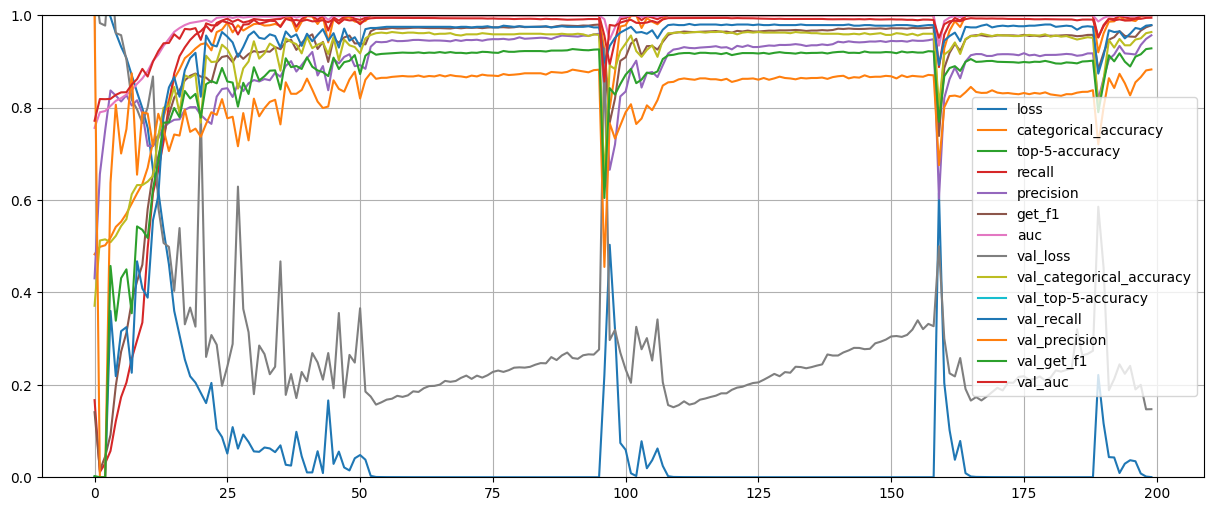

In [ ]:
import pandas as pd
plt.rcParams['figure.figsize']=(15,6)
pd.DataFrame(history.history).plot()
plt.grid()
plt.gca().set_ylim(0,1)
plt.savefig("Bivit_without_Aug.png")
plt.show()

In [ ]:
history.history.keys()

dict_keys(['loss', 'categorical_accuracy', 'top-5-accuracy', 'recall', 'precision', 'get_f1', 'auc', 'val_loss', 'val_categorical_accuracy', 'val_top-5-accuracy', 'val_recall', 'val_precision', 'val_get_f1', 'val_auc'])

In [ ]:
print(np.std(history.history['val_categorical_accuracy']))
print(np.std(history.history['val_recall']))
print(np.std(history.history['val_precision']))
print(np.std(history.history['val_get_f1']))
print(np.std(history.history['val_auc']))
print(np.mean(history.history['val_categorical_accuracy']))
print(np.mean(history.history['val_recall']))
print(np.mean(history.history['val_precision']))
print(np.mean(history.history['val_get_f1']))
print(np.mean(history.history['val_auc']))

0.10196142075036488
0.1737305963430349
0.09964760101990719
0.1451589362163345
0.03841378109314439
0.9160687465965748
0.9202187541185413
0.8260302422940731
0.8628288361534941
0.978522601723671


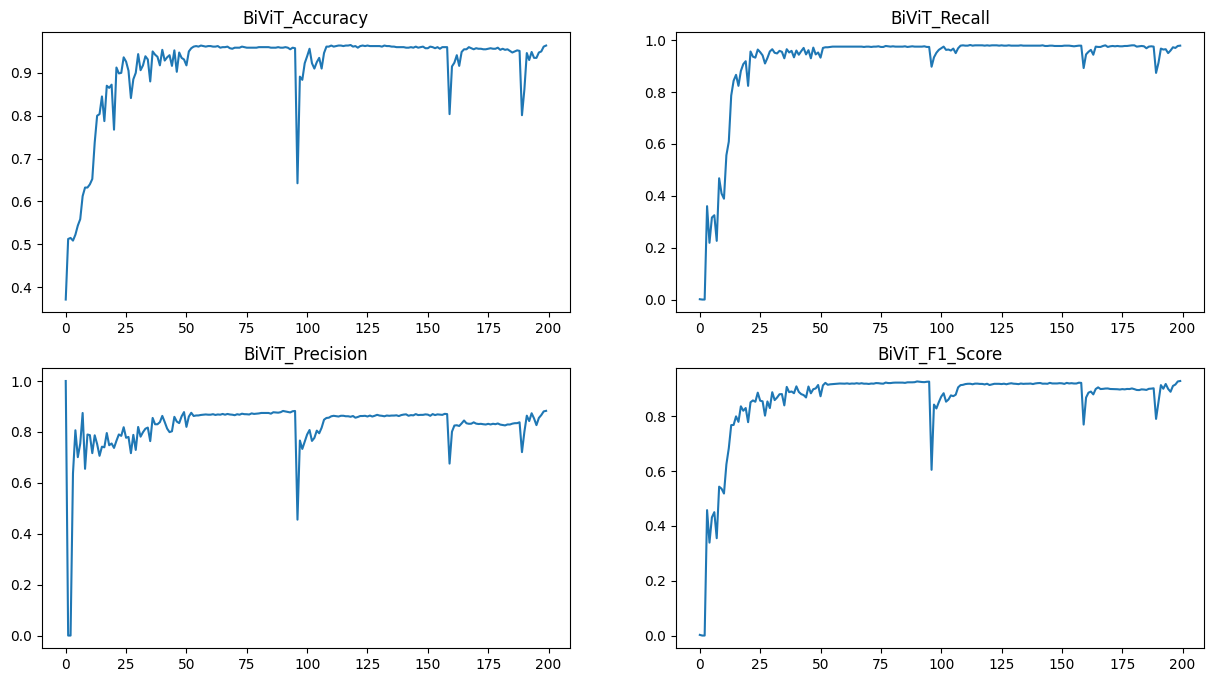

In [ ]:
import pandas as pd
plt.rcParams['figure.figsize']=(15,8)
plt.subplot(2,2,1)
plt.plot(history.history['val_categorical_accuracy'])
plt.title('BiViT_Accuracy')
plt.subplot(2,2,2)
plt.plot(history.history['val_recall'])
plt.title('BiViT_Recall')
plt.subplot(2,2,3)
plt.plot(history.history['val_precision'])
plt.title('BiViT_Precision')
plt.subplot(2,2,4)
plt.plot(history.history['val_get_f1'])
plt.title('BiViT_F1_Score')
plt.savefig("BiVit_without_Aug_seperate.png")
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test,axis=1),np.argmax(cct_model.predict(x_test),axis=1)))

25/25 [==============================] - 2s 33ms/step
              precision    recall  f1-score   support

           0       0.98      0.93      0.95       111
           1       0.83      0.83      0.83         6
           2       0.96      0.98      0.97       390
           3       0.97      0.95      0.96       293

    accuracy                           0.96       800
   macro avg       0.93      0.92      0.93       800
weighted avg       0.96      0.96      0.96       800



In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(np.argmax(y_test,axis=1),np.argmax(cct_model.predict(x_test),axis=1))

25/25 [==============================] - 1s 31ms/step


array([[103,   1,   2,   5],
       [  1,   5,   0,   0],
       [  1,   0, 384,   5],
       [  0,   0,  14, 279]])

25/25 [==============================] - 1s 31ms/step


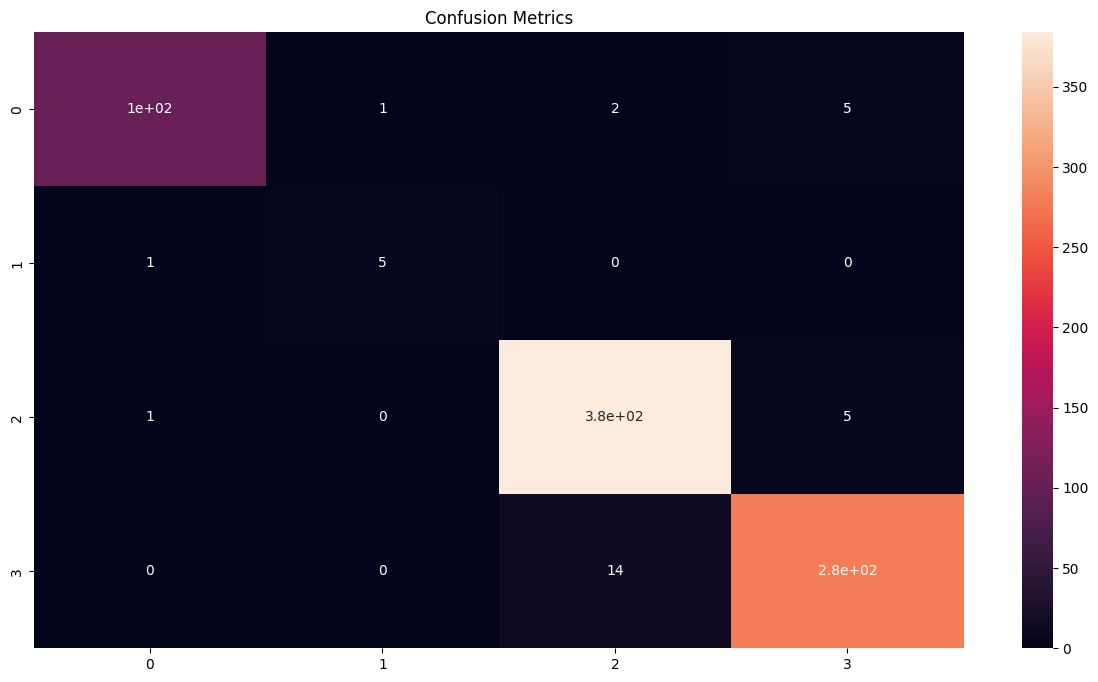

In [ ]:
import seaborn as sns
sns.heatmap(confusion_matrix(np.argmax(y_test,axis=1),np.argmax(cct_model.predict(x_test),axis=1)),annot=True)
plt.title('Confusion Metrics')
plt.savefig("BiVit_without_Aug_confusion.png")
plt.show()

## Transfer Learning

## DenseNet 121

In [ ]:
import tensorflow as tf
model = tf.keras.applications.densenet.DenseNet121(
    include_top=False,
    weights="imagenet",
    input_shape=(128,128,3)
)
model.trainable=False
output = keras.layers.Flatten()(model.output)
out = keras.layers.Dense(4,activation='sigmoid')(output)
classifier = keras.models.Model([model.input], [out])

import keras.backend as K

def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

classifier.compile(
    optimizer = tf.keras.optimizers.Adam(lr=0.001), 
    loss='categorical_crossentropy', 
    metrics=[keras.metrics.CategoricalAccuracy(), keras.metrics.Recall(), keras.metrics.Precision(),get_f1, keras.metrics.AUC()]
  )

history = classifier.fit(
    x_train,y_train,
    epochs=50,
    validation_data= (x_test,y_test),
    batch_size=32)

Epoch 1/50
175/175 [==============================] - 27s 59ms/step - loss: 1.6367 - categorical_accuracy: 0.1777 - recall: 0.9907 - precision: 0.2788 - get_f1: 0.4397 - auc: 0.5737 - val_loss: 0.8353 - val_categorical_accuracy: 0.2163 - val_recall: 1.0000 - val_precision: 0.2500 - val_get_f1: 0.4000 - val_auc: 0.5000
Epoch 2/50
175/175 [==============================] - 7s 40ms/step - loss: 0.7698 - categorical_accuracy: 0.1798 - recall: 1.0000 - precision: 0.2500 - get_f1: 0.4000 - auc: 0.5000 - val_loss: 0.9327 - val_categorical_accuracy: 0.1612 - val_recall: 1.0000 - val_precision: 0.2500 - val_get_f1: 0.4000 - val_auc: 0.5006
Epoch 3/50
175/175 [==============================] - 7s 42ms/step - loss: 0.7584 - categorical_accuracy: 0.1923 - recall: 1.0000 - precision: 0.2501 - get_f1: 0.4001 - auc: 0.5061 - val_loss: 1.2584 - val_categorical_accuracy: 0.1625 - val_recall: 1.0000 - val_precision: 0.2500 - val_get_f1: 0.4000 - val_auc: 0.5017
Epoch 4/50
175/175 [======================

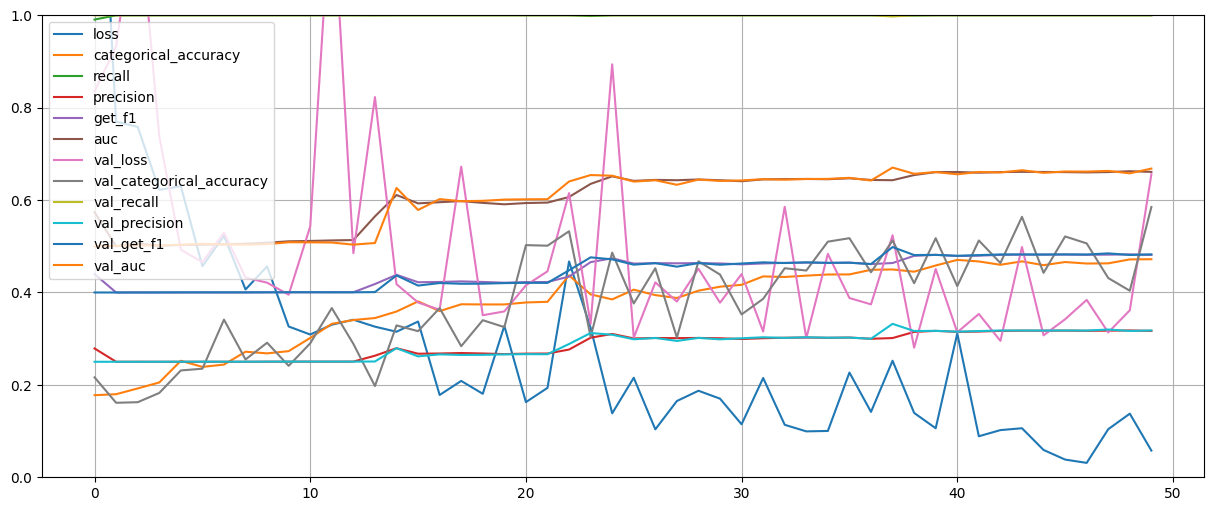

In [ ]:
import pandas as pd
plt.rcParams['figure.figsize']=(15,6)
pd.DataFrame(history.history).plot()
plt.grid()
plt.gca().set_ylim(0,1)
plt.savefig("Densenet121_without_Aug.png")
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test,axis=1),np.argmax(classifier.predict(x_test),axis=1)))

25/25 [==============================] - 4s 35ms/step
              precision    recall  f1-score   support

           0       0.46      0.93      0.61       119
           1       1.00      0.83      0.91         6
           2       0.62      0.84      0.71       396
           3       1.00      0.08      0.14       279

    accuracy                           0.58       800
   macro avg       0.77      0.67      0.59       800
weighted avg       0.73      0.58      0.50       800



In [ ]:
history.history.keys()

dict_keys(['loss', 'categorical_accuracy', 'recall', 'precision', 'get_f1', 'auc', 'val_loss', 'val_categorical_accuracy', 'val_recall', 'val_precision', 'val_get_f1', 'val_auc'])

In [ ]:
print(np.std(history.history['val_categorical_accuracy']))
print(np.std(history.history['val_recall']))
print(np.std(history.history['val_precision']))
print(np.std(history.history['val_get_f1']))
print(np.std(history.history['val_auc']))

0.113476870601847
0.00034999966621398923
0.027850493259764377
0.033843297507570716
0.06452149914720373


In [ ]:
print(np.mean(history.history['val_categorical_accuracy']))
print(np.mean(history.history['val_recall']))
print(np.mean(history.history['val_precision']))
print(np.mean(history.history['val_get_f1']))
print(np.mean(history.history['val_auc']))

0.38374999940395355
0.9999500000476838
0.2859375488758087
0.44406442999839785
0.6026329624652863


In [ ]:
import keras.backend as K
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

## Resnet 50

In [ ]:
import tensorflow as tf
model = tf.keras.applications.resnet50.ResNet50(
    include_top=False,
    weights="imagenet",
    input_shape=(128,128,3)
)
model.trainable=False
output = keras.layers.Flatten()(model.output)
out = keras.layers.Dense(4,activation='sigmoid')(output)
classifier = keras.models.Model([model.input], [out])

classifier.compile(
    optimizer = tf.keras.optimizers.Adam(lr=0.001), 
    loss='categorical_crossentropy', 
    metrics=[keras.metrics.CategoricalAccuracy(), keras.metrics.Recall(), keras.metrics.Precision(),get_f1, keras.metrics.AUC()]
  )

history = classifier.fit(
    x_train,y_train,
    epochs=50,
    validation_data= (x_test,y_test),
    batch_size=32)

Epoch 1/50
175/175 [==============================] - 15s 50ms/step - loss: 1.0395 - categorical_accuracy: 0.5111 - recall_1: 0.9402 - precision_1: 0.3699 - get_f1: 0.5333 - auc: 0.7941 - val_loss: 0.9287 - val_categorical_accuracy: 0.5750 - val_recall_1: 0.9550 - val_precision_1: 0.3981 - val_get_f1: 0.5624 - val_auc: 0.8391
Epoch 2/50
175/175 [==============================] - 7s 41ms/step - loss: 0.9556 - categorical_accuracy: 0.5430 - recall_1: 0.9545 - precision_1: 0.3867 - get_f1: 0.5524 - auc: 0.8243 - val_loss: 0.9470 - val_categorical_accuracy: 0.5387 - val_recall_1: 0.9837 - val_precision_1: 0.3488 - val_get_f1: 0.5153 - val_auc: 0.8346
Epoch 3/50
175/175 [==============================] - 9s 50ms/step - loss: 0.9162 - categorical_accuracy: 0.5727 - recall_1: 0.9564 - precision_1: 0.3904 - get_f1: 0.5557 - auc: 0.8380 - val_loss: 0.8744 - val_categorical_accuracy: 0.6187 - val_recall_1: 0.9837 - val_precision_1: 0.3690 - val_get_f1: 0.5371 - val_auc: 0.8621
Epoch 4/50
175/175

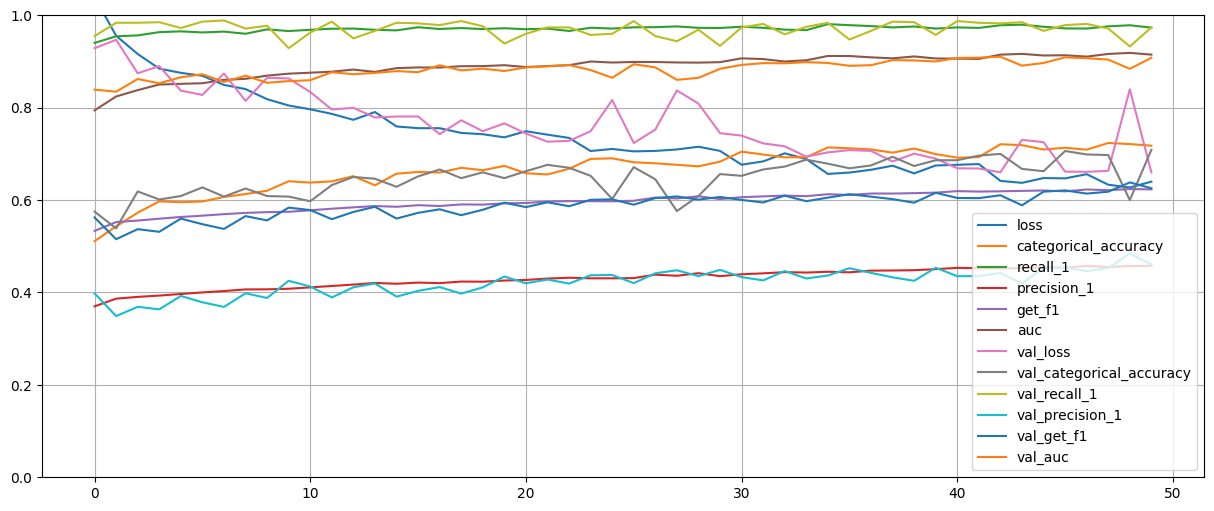

In [ ]:
plt.rcParams['figure.figsize']=(15,6)
pd.DataFrame(history.history).plot()
plt.grid()
plt.gca().set_ylim(0,1)
plt.savefig("Resnet50_without_Aug.png")
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test,axis=1),np.argmax(classifier.predict(x_test),axis=1)))

25/25 [==============================] - 2s 37ms/step
              precision    recall  f1-score   support

           0       0.78      0.45      0.57       111
           1       0.89      1.00      0.94         8
           2       0.70      0.92      0.79       405
           3       0.71      0.49      0.58       276

    accuracy                           0.71       800
   macro avg       0.77      0.72      0.72       800
weighted avg       0.71      0.71      0.69       800



In [ ]:
print(np.std(history.history['val_categorical_accuracy']))
print(np.std(history.history['val_recall_1']))
print(np.std(history.history['val_precision_1']))
print(np.std(history.history['val_get_f1']))
print(np.std(history.history['val_auc']))

0.03806738206425554
0.015978131355621213
0.027836213352700395
0.026173196098396953
0.01869395835918317


In [ ]:
print(np.mean(history.history['val_categorical_accuracy']))
print(np.mean(history.history['val_recall_1']))
print(np.mean(history.history['val_precision_1']))
print(np.mean(history.history['val_get_f1']))
print(np.mean(history.history['val_auc']))

0.6489249992370606
0.9703249967098236
0.42226764917373655
0.5881532979011536
0.8827841889858246


## Vgg16

In [ ]:
import tensorflow as tf

import keras.backend as K
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

model = tf.keras.applications.vgg16.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(128,128,3)
)
model.trainable=False
output = keras.layers.Flatten()(model.output)
out = keras.layers.Dense(4,activation='sigmoid')(output)
classifier = keras.models.Model([model.input], [out])

classifier.compile(
    optimizer = tf.keras.optimizers.Adam(lr=0.001), 
    loss='categorical_crossentropy', 
    metrics=[keras.metrics.CategoricalAccuracy(), keras.metrics.Recall(), keras.metrics.Precision(), get_f1, keras.metrics.AUC()]
  )

history = classifier.fit(
    x_train,y_train,
    epochs=50,
    validation_data= (x_test,y_test),
    batch_size=32)

58889256/58889256 [==============================] - 0s 0us/step


Epoch 1/50
175/175 [==============================] - 14s 51ms/step - loss: 0.9526 - categorical_accuracy: 0.5527 - recall_2: 0.9680 - precision_2: 0.3694 - get_f1: 0.5370 - auc_1: 0.8248 - val_loss: 0.8150 - val_categorical_accuracy: 0.6263 - val_recall_2: 0.9787 - val_precision_2: 0.3878 - val_get_f1: 0.5560 - val_auc_1: 0.8707
Epoch 2/50
175/175 [==============================] - 8s 47ms/step - loss: 0.7922 - categorical_accuracy: 0.6486 - recall_2: 0.9779 - precision_2: 0.3947 - get_f1: 0.5634 - auc_1: 0.8782 - val_loss: 0.7698 - val_categorical_accuracy: 0.6625 - val_recall_2: 0.9787 - val_precision_2: 0.4049 - val_get_f1: 0.5731 - val_auc_1: 0.8780
Epoch 3/50
175/175 [==============================] - 8s 47ms/step - loss: 0.7116 - categorical_accuracy: 0.6879 - recall_2: 0.9796 - precision_2: 0.4092 - get_f1: 0.5783 - auc_1: 0.8993 - val_loss: 0.6994 - val_categorical_accuracy: 0.6862 - val_recall_2: 0.9650 - val_precision_2: 0.4294 - val_get_f1: 0.5945 - val_auc_1: 0.8969
Epoch 

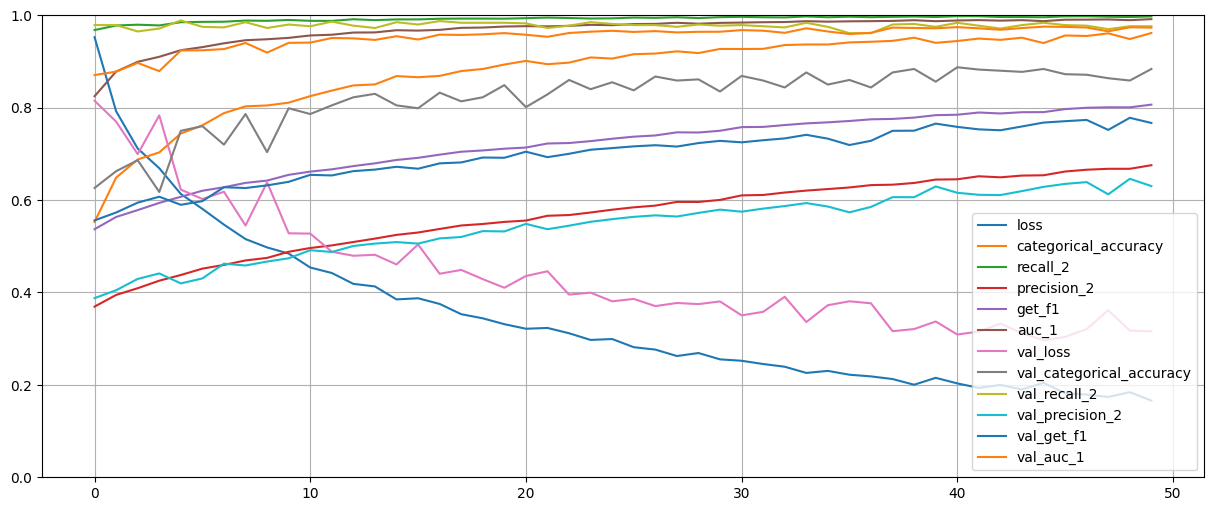

In [ ]:
pd.DataFrame(history.history).plot()
plt.grid()
plt.gca().set_ylim(0,1)
plt.savefig("Vgg16_without_Aug.png")
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test,axis=1),np.argmax(classifier.predict(x_test),axis=1)))

25/25 [==============================] - 1s 41ms/step
              precision    recall  f1-score   support

           0       0.76      0.92      0.83       111
           1       1.00      1.00      1.00         8
           2       0.96      0.86      0.90       405
           3       0.85      0.91      0.88       276

    accuracy                           0.88       800
   macro avg       0.89      0.92      0.90       800
weighted avg       0.89      0.88      0.89       800



In [ ]:
print(np.std(history.history['val_categorical_accuracy']))
print(np.std(history.history['val_recall_2']))
print(np.std(history.history['val_precision_2']))
print(np.std(history.history['val_get_f1']))
print(np.std(history.history['val_auc_1']))

0.06617731589655926
0.00590153217103048
0.06794072009377798
0.05770203536908553
0.02543976314536327


In [ ]:
print(np.mean(history.history['val_categorical_accuracy']))
print(np.mean(history.history['val_recall_2']))
print(np.mean(history.history['val_precision_2']))
print(np.mean(history.history['val_get_f1']))
print(np.mean(history.history['val_auc_1']))

0.8219999992847442
0.9778750038146973
0.5447719889879227
0.6978539431095123
0.9529275250434875


## Inception Resnet V2

In [ ]:
import tensorflow as tf

import keras.backend as K
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

model = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(
    include_top=False,
    weights="imagenet",
    input_shape=(128,128,3)
)
model.trainable=False
output = keras.layers.Flatten()(model.output)
out = keras.layers.Dense(4,activation='sigmoid')(output)
classifier = keras.models.Model([model.input], [out])

classifier.compile(
    optimizer = tf.keras.optimizers.Adam(lr=0.001), 
    loss='categorical_crossentropy', 
    metrics=[keras.metrics.CategoricalAccuracy(), keras.metrics.Recall(), keras.metrics.Precision(), get_f1, keras.metrics.AUC()]
  )

history = classifier.fit(
    x_train,y_train,
    epochs=50,
    validation_data= (x_test,y_test),
    batch_size=32)

219055592/219055592 [==============================] - 2s 0us/step


Epoch 1/50
175/175 [==============================] - 29s 93ms/step - loss: 1.6392 - categorical_accuracy: 0.5184 - recall_3: 0.9916 - precision_3: 0.2959 - get_f1: 0.4592 - auc_2: 0.6755 - val_loss: 2.0900 - val_categorical_accuracy: 0.3975 - val_recall_3: 1.0000 - val_precision_3: 0.2564 - val_get_f1: 0.4082 - val_auc_2: 0.6333
Epoch 2/50
175/175 [==============================] - 12s 67ms/step - loss: 1.0893 - categorical_accuracy: 0.6005 - recall_3: 0.9995 - precision_3: 0.2778 - get_f1: 0.4365 - auc_2: 0.6672 - val_loss: 1.0423 - val_categorical_accuracy: 0.6087 - val_recall_3: 1.0000 - val_precision_3: 0.3175 - val_get_f1: 0.4820 - val_auc_2: 0.6694
Epoch 3/50
175/175 [==============================] - 12s 67ms/step - loss: 0.8687 - categorical_accuracy: 0.6611 - recall_3: 0.9995 - precision_3: 0.2963 - get_f1: 0.4595 - auc_2: 0.6776 - val_loss: 1.2398 - val_categorical_accuracy: 0.5387 - val_recall_3: 0.9975 - val_precision_3: 0.3262 - val_get_f1: 0.4917 - val_auc_2: 0.6681
Epoc

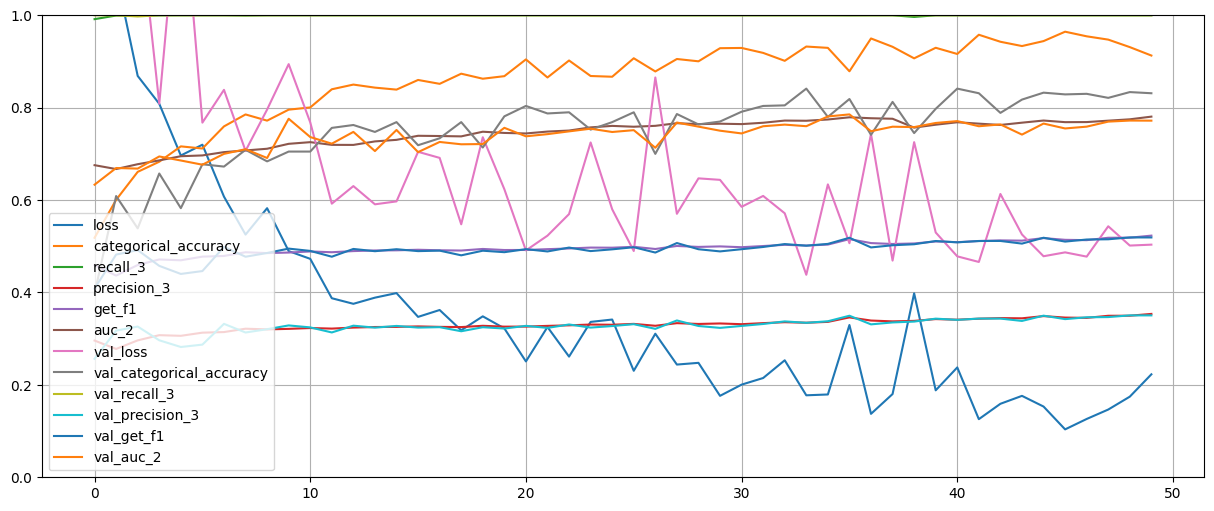

In [ ]:
pd.DataFrame(history.history).plot()
plt.grid()
plt.gca().set_ylim(0,1)
plt.savefig("Inception_ResnerV2_without_Aug.png")
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test,axis=1),np.argmax(classifier.predict(x_test),axis=1)))

25/25 [==============================] - 5s 63ms/step
              precision    recall  f1-score   support

           0       0.89      0.73      0.80       111
           1       1.00      0.75      0.86         8
           2       0.90      0.82      0.86       405
           3       0.73      0.88      0.80       276

    accuracy                           0.83       800
   macro avg       0.88      0.80      0.83       800
weighted avg       0.84      0.83      0.83       800



In [ ]:
print(np.std(history.history['val_categorical_accuracy']))
print(np.std(history.history['val_recall_3']))
print(np.std(history.history['val_precision_3']))
print(np.std(history.history['val_get_f1']))
print(np.std(history.history['val_auc_2']))

0.0837000801648134
0.0003499996662139892
0.017442994055089037
0.020313990008779214
0.03345164488017867


In [ ]:
print(np.mean(history.history['val_categorical_accuracy']))
print(np.mean(history.history['val_recall_3']))
print(np.mean(history.history['val_precision_3']))
print(np.mean(history.history['val_get_f1']))
print(np.mean(history.history['val_auc_2']))

0.7518750005960464
0.9999500000476838
0.3276579588651657
0.4934595572948456
0.7385132730007171


## Inception v3

In [ ]:
import tensorflow as tf

import keras.backend as K
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

model = tf.keras.applications.inception_v3.InceptionV3(
    include_top=False,
    weights="imagenet",
    input_shape=(128,128,3)
)
model.trainable=False
output = keras.layers.Flatten()(model.output)
out = keras.layers.Dense(4,activation='sigmoid')(output)
classifier = keras.models.Model([model.input], [out])

classifier.compile(
    optimizer = tf.keras.optimizers.Adam(lr=0.001), 
    loss='categorical_crossentropy', 
    metrics=[keras.metrics.CategoricalAccuracy(), keras.metrics.Recall(), keras.metrics.Precision(), get_f1, keras.metrics.AUC()]
  )

history = classifier.fit(
    x_train,y_train,
    epochs=50,
    validation_data= (x_test,y_test),
    batch_size=32)

87910968/87910968 [==============================] - 1s 0us/step


Epoch 1/50
175/175 [==============================] - 14s 49ms/step - loss: 1.5100 - categorical_accuracy: 0.5370 - recall_4: 0.9943 - precision_4: 0.2796 - get_f1: 0.4398 - auc_3: 0.6674 - val_loss: 0.9458 - val_categorical_accuracy: 0.6050 - val_recall_4: 1.0000 - val_precision_4: 0.2731 - val_get_f1: 0.4292 - val_auc_3: 0.6498
Epoch 2/50
175/175 [==============================] - 6s 33ms/step - loss: 0.9336 - categorical_accuracy: 0.6309 - recall_4: 0.9998 - precision_4: 0.3003 - get_f1: 0.4632 - auc_3: 0.6856 - val_loss: 0.9457 - val_categorical_accuracy: 0.6500 - val_recall_4: 1.0000 - val_precision_4: 0.3004 - val_get_f1: 0.4621 - val_auc_3: 0.7163
Epoch 3/50
175/175 [==============================] - 6s 36ms/step - loss: 0.8265 - categorical_accuracy: 0.6761 - recall_4: 1.0000 - precision_4: 0.3017 - get_f1: 0.4646 - auc_3: 0.6965 - val_loss: 1.0344 - val_categorical_accuracy: 0.6425 - val_recall_4: 0.9900 - val_precision_4: 0.3300 - val_get_f1: 0.4950 - val_auc_3: 0.6652
Epoch 

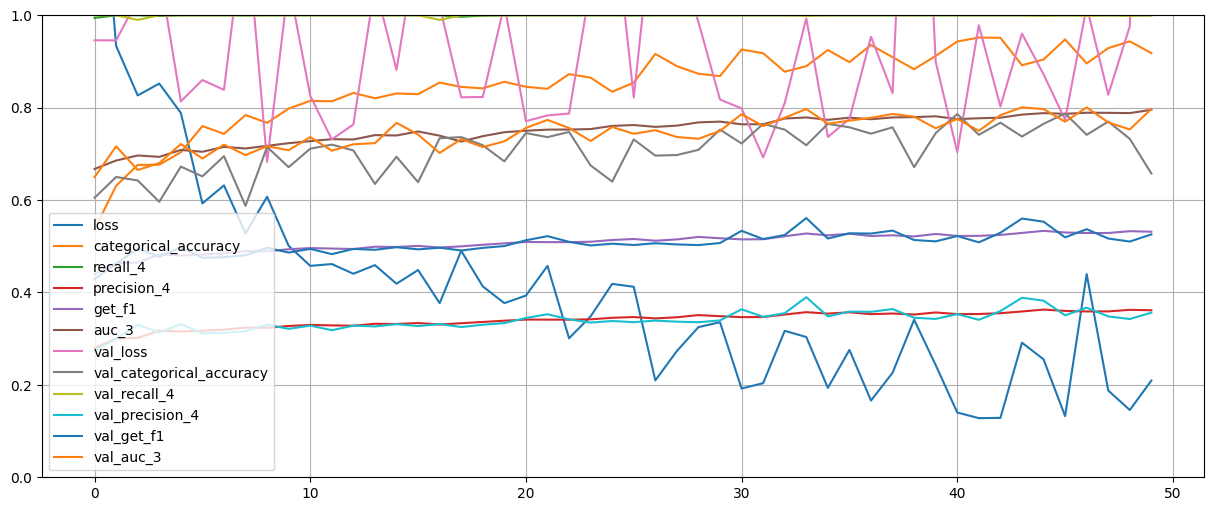

In [ ]:
pd.DataFrame(history.history).plot()
plt.grid()
plt.gca().set_ylim(0,1)
plt.savefig("InceptionV3_without_Aug.png")
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test,axis=1),np.argmax(classifier.predict(x_test),axis=1)))

25/25 [==============================] - 3s 31ms/step
              precision    recall  f1-score   support

           0       0.65      0.82      0.73       111
           1       1.00      0.75      0.86         8
           2       0.64      0.97      0.77       405
           3       0.95      0.13      0.22       276

    accuracy                           0.66       800
   macro avg       0.81      0.67      0.64       800
weighted avg       0.75      0.66      0.58       800



In [ ]:
print(np.std(history.history['val_categorical_accuracy']))
print(np.std(history.history['val_recall_4']))
print(np.std(history.history['val_precision_4']))
print(np.std(history.history['val_get_f1']))
print(np.std(history.history['val_auc_3']))
print(np.mean(history.history['val_categorical_accuracy']))
print(np.mean(history.history['val_recall_4']))
print(np.mean(history.history['val_precision_4']))
print(np.mean(history.history['val_get_f1']))
print(np.mean(history.history['val_auc_3']))

0.049610632727930724
0.001968500999585273
0.02093618762306037
0.02346793399992197
0.0356739618075086
0.709599996805191
0.9994999980926513
0.3396574956178665
0.5067803734540939
0.7455497360229493


## Efficient B0

In [ ]:
import tensorflow as tf

import keras.backend as K
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val


model = tf.keras.applications.efficientnet.EfficientNetB0(
    include_top=False,
    weights="imagenet",
    input_shape=(128,128,3)
)
model.trainable=False
output = keras.layers.Flatten()(model.output)
out = keras.layers.Dense(4,activation='sigmoid')(output)
classifier = keras.models.Model([model.input], [out])

classifier.compile(
    optimizer = tf.keras.optimizers.Adam(lr=0.001), 
    loss='categorical_crossentropy', 
    metrics=[keras.metrics.CategoricalAccuracy(), keras.metrics.Recall(), keras.metrics.Precision(), get_f1, keras.metrics.AUC()]
  )

history = classifier.fit(
    x_train,y_train,
    epochs=50,
    validation_data= (x_test,y_test),
    batch_size=32)

Epoch 1/50
175/175 [==============================] - 25s 44ms/step - loss: 1.4313 - categorical_accuracy: 0.4134 - recall: 0.9755 - precision: 0.3124 - get_f1: 0.4759 - auc: 0.7254 - val_loss: 1.0450 - val_categorical_accuracy: 0.5038 - val_recall: 0.9937 - val_precision: 0.3313 - val_get_f1: 0.4969 - val_auc: 0.7916
Epoch 2/50
175/175 [==============================] - 6s 32ms/step - loss: 1.2673 - categorical_accuracy: 0.4321 - recall: 0.9916 - precision: 0.3108 - get_f1: 0.4763 - auc: 0.7380 - val_loss: 1.2361 - val_categorical_accuracy: 0.3638 - val_recall: 0.9937 - val_precision: 0.3313 - val_get_f1: 0.4969 - val_auc: 0.7516
Epoch 3/50
175/175 [==============================] - 5s 28ms/step - loss: 1.1943 - categorical_accuracy: 0.4400 - recall: 0.9918 - precision: 0.3099 - get_f1: 0.4754 - auc: 0.7473 - val_loss: 1.0931 - val_categorical_accuracy: 0.5038 - val_recall: 0.9937 - val_precision: 0.3313 - val_get_f1: 0.4969 - val_auc: 0.8042
Epoch 4/50
175/175 [======================

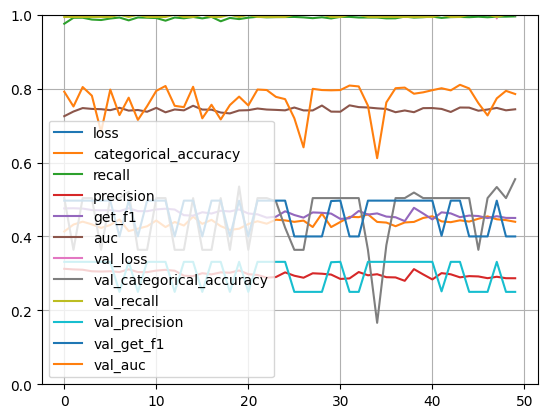

In [ ]:
plt.rcParams['figure.figsize']=(15,6)
pd.DataFrame(history.history).plot()
plt.grid()
plt.gca().set_ylim(0,1)
plt.savefig("EfficientB0_without_Aug.png")
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test,axis=1),np.argmax(classifier.predict(x_test),axis=1)))

25/25 [==============================] - 2s 25ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       101
           1       0.00      0.00      0.00         5
           2       0.57      0.92      0.70       403
           3       0.51      0.25      0.34       291

    accuracy                           0.56       800
   macro avg       0.27      0.29      0.26       800
weighted avg       0.47      0.56      0.48       800



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print(np.std(history.history['val_categorical_accuracy']))
print(np.std(history.history['val_recall']))
print(np.std(history.history['val_precision']))
print(np.std(history.history['val_get_f1']))
print(np.std(history.history['val_auc']))
print(np.mean(history.history['val_categorical_accuracy']))
print(np.mean(history.history['val_recall']))
print(np.mean(history.history['val_precision']))
print(np.mean(history.history['val_get_f1']))
print(np.mean(history.history['val_auc']))

0.07795562199085684
0.0030000114440917962
0.03894647345965143
0.04643361639883116
0.04175104797728825
0.4563750186562538
0.995999984741211
0.3020105874538422
0.4620168894529343
0.7685164165496826


## EfficientNet B1

In [ ]:
import tensorflow as tf

import keras.backend as K
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

model = tf.keras.applications.efficientnet.EfficientNetB1(
    include_top=False,
    weights="imagenet",
    input_shape=(128,128,3)
)
model.trainable=False
output = keras.layers.Flatten()(model.output)
out = keras.layers.Dense(4,activation='sigmoid')(output)
classifier = keras.models.Model([model.input], [out])

classifier.compile(
    optimizer = tf.keras.optimizers.Adam(lr=0.001), 
    loss='categorical_crossentropy', 
    metrics=[keras.metrics.CategoricalAccuracy(), keras.metrics.Recall(), keras.metrics.Precision(), get_f1, keras.metrics.AUC()]
  )

history = classifier.fit(
    x_train,y_train,
    epochs=50,
    validation_data= (x_test,y_test),
    batch_size=32)

27018416/27018416 [==============================] - 0s 0us/step


Epoch 1/50
175/175 [==============================] - 21s 59ms/step - loss: 1.4830 - categorical_accuracy: 0.4229 - recall_1: 0.9837 - precision_1: 0.2760 - get_f1: 0.4360 - auc_1: 0.7114 - val_loss: 1.6301 - val_categorical_accuracy: 0.5038 - val_recall_1: 1.0000 - val_precision_1: 0.2500 - val_get_f1: 0.4000 - val_auc_1: 0.6999
Epoch 2/50
175/175 [==============================] - 6s 35ms/step - loss: 1.3229 - categorical_accuracy: 0.4223 - recall_1: 0.9950 - precision_1: 0.2918 - get_f1: 0.4557 - auc_1: 0.7089 - val_loss: 1.5788 - val_categorical_accuracy: 0.3638 - val_recall_1: 1.0000 - val_precision_1: 0.2500 - val_get_f1: 0.4000 - val_auc_1: 0.7307
Epoch 3/50
175/175 [==============================] - 7s 38ms/step - loss: 1.3301 - categorical_accuracy: 0.4264 - recall_1: 0.9946 - precision_1: 0.2878 - get_f1: 0.4512 - auc_1: 0.7088 - val_loss: 1.3692 - val_categorical_accuracy: 0.5038 - val_recall_1: 0.9937 - val_precision_1: 0.3313 - val_get_f1: 0.4969 - val_auc_1: 0.7660
Epoch 

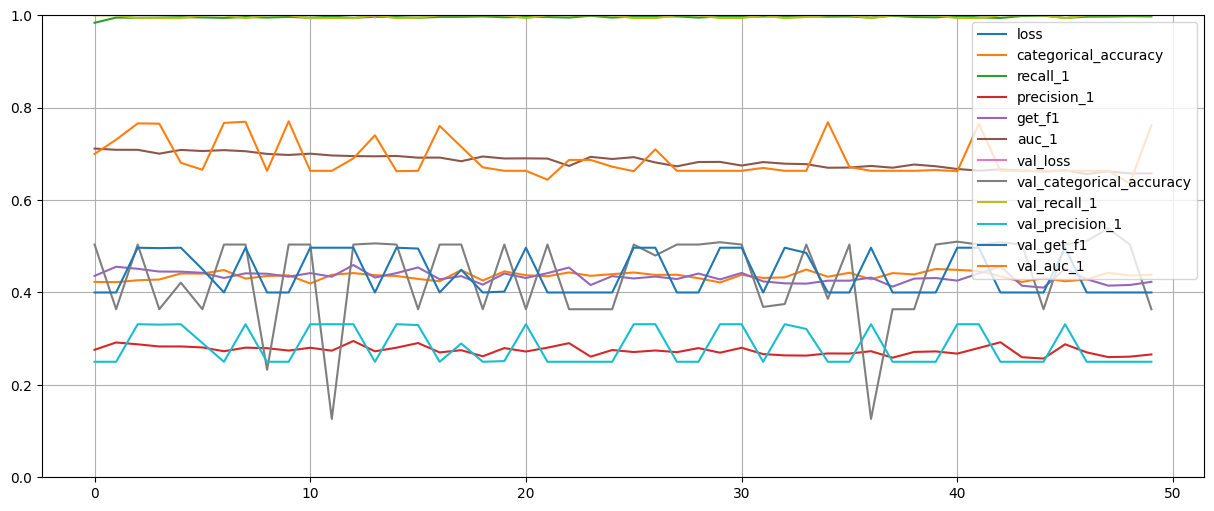

In [ ]:
plt.rcParams['figure.figsize']=(15,6)
pd.DataFrame(history.history).plot()
plt.grid()
plt.gca().set_ylim(0,1)
plt.savefig("EfficientB1_without_Aug.png")
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test,axis=1),np.argmax(classifier.predict(x_test),axis=1)))

25/25 [==============================] - 3s 32ms/step
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       101
           1       0.00      0.00      0.00         5
           2       0.00      0.00      0.00       403
           3       0.36      1.00      0.53       291

    accuracy                           0.36       800
   macro avg       0.09      0.25      0.13       800
weighted avg       0.13      0.36      0.19       800



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
print(np.std(history.history['val_categorical_accuracy']))
print(np.std(history.history['val_recall_1']))
print(np.std(history.history['val_precision_1']))
print(np.std(history.history['val_get_f1']))
print(np.std(history.history['val_auc_1']))
print(np.mean(history.history['val_categorical_accuracy']))
print(np.mean(history.history['val_recall_1']))
print(np.mean(history.history['val_precision_1']))
print(np.mean(history.history['val_get_f1']))
print(np.mean(history.history['val_auc_1']))

0.09555717587507509
0.0029938589745431153
0.03895794706827725
0.04649010722605179
0.040605763618104425
0.43830001562833787
0.9975749909877777
0.28387505412101743
0.4405014753341675
0.6889509916305542


## VGG19

In [ ]:
import tensorflow as tf

import keras.backend as K
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

model = tf.keras.applications.vgg19.VGG19(
    include_top=False,
    weights="imagenet",
    input_shape=(128,128,3)
)
model.trainable=False
output = keras.layers.Flatten()(model.output)
out = keras.layers.Dense(4,activation='sigmoid')(output)
classifier = keras.models.Model([model.input], [out])

classifier.compile(
    optimizer = tf.keras.optimizers.Adam(lr=0.001), 
    loss='categorical_crossentropy', 
    metrics=[keras.metrics.CategoricalAccuracy(), keras.metrics.Recall(), keras.metrics.Precision(), get_f1, keras.metrics.AUC()]
  )

history = classifier.fit(
    x_train,y_train,
    epochs=50,
    validation_data= (x_test,y_test),
    batch_size=32)

Epoch 1/50
175/175 [==============================] - 23s 62ms/step - loss: 0.9578 - categorical_accuracy: 0.5516 - recall: 0.9841 - precision: 0.3525 - get_f1: 0.5201 - auc: 0.8222 - val_loss: 0.8874 - val_categorical_accuracy: 0.6137 - val_recall: 0.9775 - val_precision: 0.3619 - val_get_f1: 0.5284 - val_auc: 0.8555
Epoch 2/50
175/175 [==============================] - 10s 55ms/step - loss: 0.8125 - categorical_accuracy: 0.6211 - recall: 0.9900 - precision: 0.3682 - get_f1: 0.5375 - auc: 0.8711 - val_loss: 0.7930 - val_categorical_accuracy: 0.6812 - val_recall: 0.9837 - val_precision: 0.3569 - val_get_f1: 0.5240 - val_auc: 0.8835
Epoch 3/50
175/175 [==============================] - 10s 55ms/step - loss: 0.7396 - categorical_accuracy: 0.6725 - recall: 0.9920 - precision: 0.3757 - get_f1: 0.5458 - auc: 0.8931 - val_loss: 0.8498 - val_categorical_accuracy: 0.6162 - val_recall: 0.9625 - val_precision: 0.4085 - val_get_f1: 0.5739 - val_auc: 0.8691
Epoch 4/50
175/175 [====================

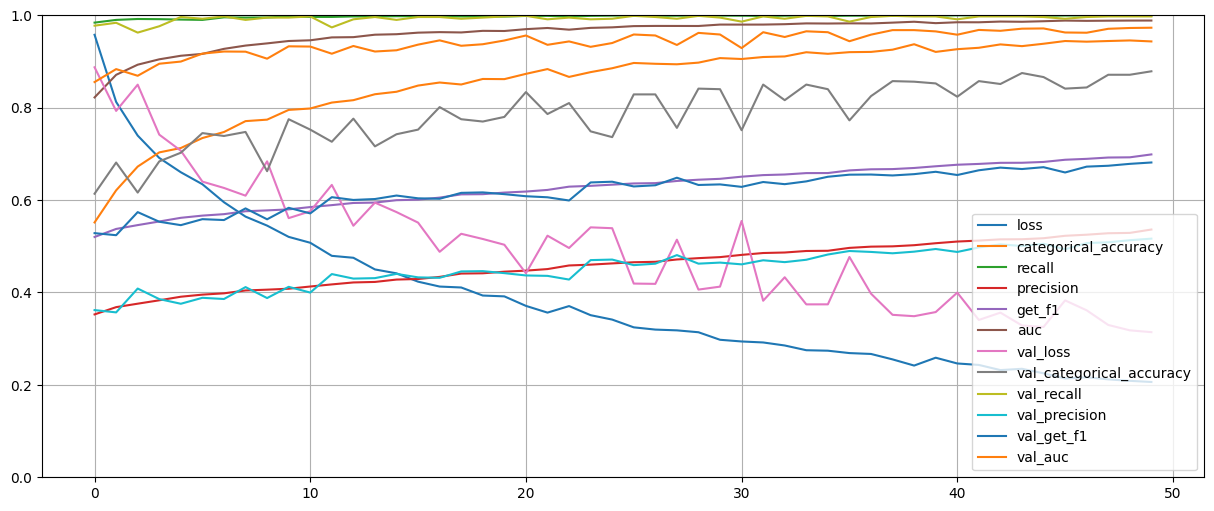

In [ ]:
plt.rcParams['figure.figsize']=(15,6)
pd.DataFrame(history.history).plot()
plt.grid()
plt.gca().set_ylim(0,1)
plt.savefig("VGG19_without_Aug.png")
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test,axis=1),np.argmax(classifier.predict(x_test),axis=1)))

25/25 [==============================] - 1s 49ms/step
              precision    recall  f1-score   support

           0       0.83      0.92      0.87       118
           1       1.00      1.00      1.00        12
           2       0.87      0.92      0.89       392
           3       0.92      0.79      0.85       278

    accuracy                           0.88       800
   macro avg       0.90      0.91      0.90       800
weighted avg       0.88      0.88      0.88       800



In [ ]:
print(np.std(history.history['val_categorical_accuracy']))
print(np.std(history.history['val_recall']))
print(np.std(history.history['val_precision']))
print(np.std(history.history['val_get_f1']))
print(np.std(history.history['val_auc']))
print(np.mean(history.history['val_categorical_accuracy']))
print(np.mean(history.history['val_recall']))
print(np.mean(history.history['val_precision']))
print(np.mean(history.history['val_get_f1']))
print(np.mean(history.history['val_auc']))

0.06663194117834151
0.0071596081939397805
0.0421396489755962
0.04110660107354399
0.027173797841694974
0.7883999967575073
0.9930499923229218
0.4522678703069687
0.6208286893367767
0.9412022066116333


## Resnet101

In [ ]:
import tensorflow as tf

import keras.backend as K
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

model = tf.keras.applications.resnet.ResNet101(
    include_top=False,
    weights="imagenet",
    input_shape=(128,128,3)
)
model.trainable=False
output = keras.layers.Flatten()(model.output)
out = keras.layers.Dense(4,activation='sigmoid')(output)
classifier = keras.models.Model([model.input], [out])

classifier.compile(
    optimizer = tf.keras.optimizers.Adam(lr=0.001), 
    loss='categorical_crossentropy', 
    metrics=[keras.metrics.CategoricalAccuracy(), keras.metrics.Recall(), keras.metrics.Precision(), get_f1, keras.metrics.AUC()]
  )

history = classifier.fit(
    x_train,y_train,
    epochs=50,
    validation_data= (x_test,y_test),
    batch_size=32)

171446536/171446536 [==============================] - 1s 0us/step


Epoch 1/50
175/175 [==============================] - 25s 95ms/step - loss: 1.0183 - categorical_accuracy: 0.5066 - recall_1: 0.9552 - precision_1: 0.3659 - get_f1: 0.5312 - auc_1: 0.7967 - val_loss: 0.9916 - val_categorical_accuracy: 0.5113 - val_recall_1: 0.9737 - val_precision_1: 0.3593 - val_get_f1: 0.5252 - val_auc_1: 0.8095
Epoch 2/50
175/175 [==============================] - 14s 78ms/step - loss: 0.9566 - categorical_accuracy: 0.5423 - recall_1: 0.9604 - precision_1: 0.3781 - get_f1: 0.5440 - auc_1: 0.8199 - val_loss: 1.0381 - val_categorical_accuracy: 0.5400 - val_recall_1: 0.8562 - val_precision_1: 0.4179 - val_get_f1: 0.5617 - val_auc_1: 0.8159
Epoch 3/50
175/175 [==============================] - 13s 76ms/step - loss: 0.9330 - categorical_accuracy: 0.5607 - recall_1: 0.9645 - precision_1: 0.3805 - get_f1: 0.5466 - auc_1: 0.8293 - val_loss: 0.9430 - val_categorical_accuracy: 0.5562 - val_recall_1: 0.9800 - val_precision_1: 0.3596 - val_get_f1: 0.5263 - val_auc_1: 0.8289
Epoc

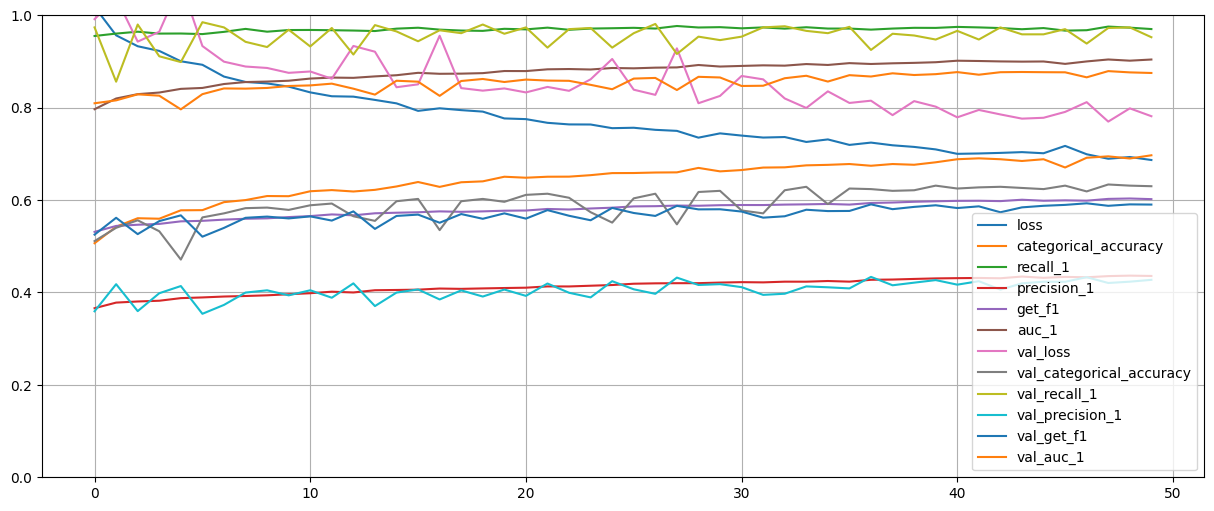

In [ ]:
pd.DataFrame(history.history).plot()
plt.grid()
plt.gca().set_ylim(0,1)
plt.savefig("Resnet101_without_Aug.png")
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test,axis=1),np.argmax(classifier.predict(x_test),axis=1)))

25/25 [==============================] - 3s 56ms/step
              precision    recall  f1-score   support

           0       0.71      0.20      0.32       118
           1       1.00      0.67      0.80        12
           2       0.66      0.81      0.73       392
           3       0.56      0.56      0.56       278

    accuracy                           0.63       800
   macro avg       0.73      0.56      0.60       800
weighted avg       0.64      0.63      0.61       800



In [ ]:
print(np.std(history.history['val_categorical_accuracy']))
print(np.std(history.history['val_recall_1']))
print(np.std(history.history['val_precision_1']))
print(np.std(history.history['val_get_f1']))
print(np.std(history.history['val_auc_1']))
print(np.mean(history.history['val_categorical_accuracy']))
print(np.mean(history.history['val_recall_1']))
print(np.mean(history.history['val_precision_1']))
print(np.mean(history.history['val_get_f1']))
print(np.mean(history.history['val_auc_1']))

0.03573377048677153
0.024707490252600363
0.018902177599288462
0.017356226723859197
0.01930064027482467
0.5933500039577484
0.9548000037670136
0.4059862023591995
0.5694778656959534
0.8543945670127868


## MobileNet

In [ ]:
import tensorflow as tf

import keras.backend as K
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

model = tf.keras.applications.mobilenet.MobileNet(
    include_top=False,
    weights="imagenet",
    input_shape=(128,128,3)
)
model.trainable=False
output = keras.layers.Flatten()(model.output)
out = keras.layers.Dense(4,activation='sigmoid')(output)
classifier = keras.models.Model([model.input], [out])

classifier.compile(
    optimizer = tf.keras.optimizers.Adam(lr=0.001), 
    loss='categorical_crossentropy', 
    metrics=[keras.metrics.CategoricalAccuracy(), keras.metrics.Recall(), keras.metrics.Precision(), get_f1, keras.metrics.AUC()]
  )

history = classifier.fit(
    x_train,y_train,
    epochs=50,
    validation_data= (x_test,y_test),
    batch_size=32)

Epoch 1/50
175/175 [==============================] - 17s 28ms/step - loss: 1.1435 - categorical_accuracy: 0.6346 - recall: 0.9761 - precision: 0.3707 - get_f1: 0.5383 - auc: 0.8459 - val_loss: 0.5001 - val_categorical_accuracy: 0.8025 - val_recall: 0.9987 - val_precision: 0.3807 - val_get_f1: 0.5515 - val_auc: 0.9214
Epoch 2/50
175/175 [==============================] - 3s 18ms/step - loss: 0.4294 - categorical_accuracy: 0.8280 - recall: 0.9986 - precision: 0.3986 - get_f1: 0.5708 - auc: 0.9415 - val_loss: 0.4089 - val_categorical_accuracy: 0.8450 - val_recall: 0.9987 - val_precision: 0.4070 - val_get_f1: 0.5786 - val_auc: 0.9489
Epoch 3/50
175/175 [==============================] - 3s 18ms/step - loss: 0.2644 - categorical_accuracy: 0.8986 - recall: 0.9998 - precision: 0.4174 - get_f1: 0.5899 - auc: 0.9672 - val_loss: 0.4207 - val_categorical_accuracy: 0.8325 - val_recall: 1.0000 - val_precision: 0.4119 - val_get_f1: 0.5840 - val_auc: 0.9436
Epoch 4/50
175/175 [======================

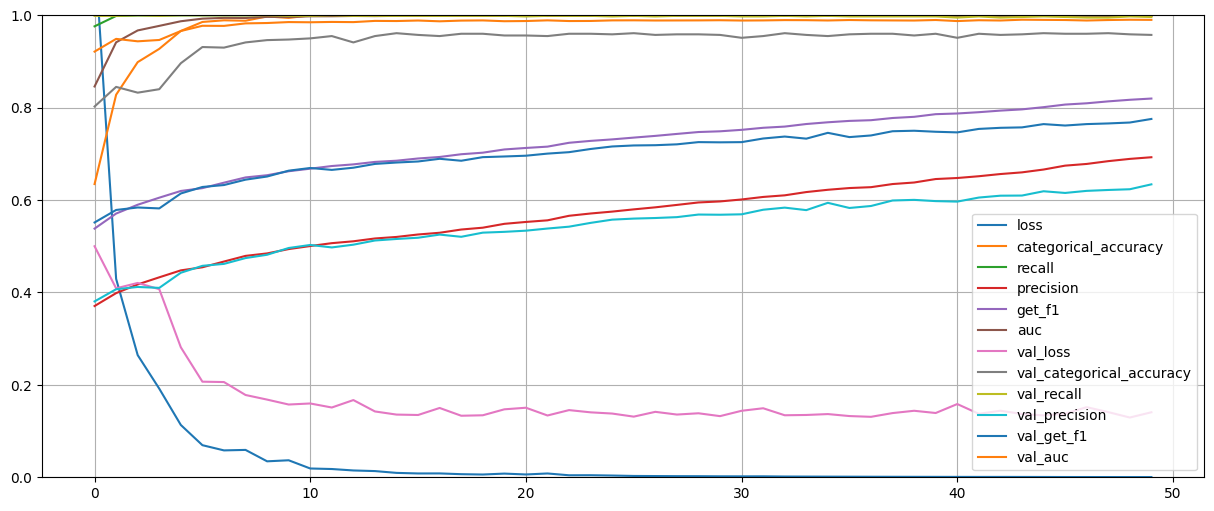

In [ ]:
plt.rcParams['figure.figsize']=(15,6)
pd.DataFrame(history.history).plot()
plt.grid()
plt.gca().set_ylim(0,1)
plt.savefig("Mobilenet_without_Aug.png")
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test,axis=1),np.argmax(classifier.predict(x_test),axis=1)))

25/25 [==============================] - 1s 15ms/step
              precision    recall  f1-score   support

           0       0.97      0.91      0.94       108
           1       1.00      1.00      1.00         2
           2       0.97      0.95      0.96       398
           3       0.94      0.98      0.96       292

    accuracy                           0.96       800
   macro avg       0.97      0.96      0.96       800
weighted avg       0.96      0.96      0.96       800



In [ ]:
print(np.std(history.history['val_categorical_accuracy']))
print(np.std(history.history['val_recall']))
print(np.std(history.history['val_precision']))
print(np.std(history.history['val_get_f1']))
print(np.std(history.history['val_auc']))
print(np.mean(history.history['val_categorical_accuracy']))
print(np.mean(history.history['val_recall']))
print(np.mean(history.history['val_precision']))
print(np.mean(history.history['val_get_f1']))
print(np.mean(history.history['val_auc']))

0.03563846907280249
0.0013287633148215982
0.06320057160733081
0.05475942797428102
0.013780044891268724
0.9441749954223633
0.9981249868869781
0.543049253821373
0.7017340397834778
0.9834850442409515


## Xception

In [ ]:
import tensorflow as tf

import keras.backend as K
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

model = tf.keras.applications.xception.Xception(
    include_top=False,
    weights="imagenet",
    input_shape=(128,128,3)
)
model.trainable=False
output = keras.layers.Flatten()(model.output)
out = keras.layers.Dense(4,activation='sigmoid')(output)
classifier = keras.models.Model([model.input], [out])

classifier.compile(
    optimizer = tf.keras.optimizers.Adam(lr=0.001), 
    loss='categorical_crossentropy', 
    metrics=[keras.metrics.CategoricalAccuracy(), keras.metrics.Recall(), keras.metrics.Precision(), get_f1, keras.metrics.AUC()]
  )

history = classifier.fit(
    x_train,y_train,
    epochs=50,
    validation_data= (x_test,y_test),
    batch_size=32)

Epoch 1/50
175/175 [==============================] - 27s 74ms/step - loss: 1.5470 - categorical_accuracy: 0.5318 - recall: 0.9821 - precision: 0.3176 - get_f1: 0.4842 - auc: 0.7409 - val_loss: 0.9233 - val_categorical_accuracy: 0.6125 - val_recall: 0.9962 - val_precision: 0.3284 - val_get_f1: 0.4940 - val_auc: 0.7600
Epoch 2/50
175/175 [==============================] - 8s 48ms/step - loss: 0.9819 - categorical_accuracy: 0.6257 - recall: 0.9995 - precision: 0.3164 - get_f1: 0.4816 - auc: 0.7709 - val_loss: 1.0194 - val_categorical_accuracy: 0.6062 - val_recall: 1.0000 - val_precision: 0.3063 - val_get_f1: 0.4690 - val_auc: 0.7838
Epoch 3/50
175/175 [==============================] - 8s 49ms/step - loss: 0.8429 - categorical_accuracy: 0.6666 - recall: 0.9989 - precision: 0.3232 - get_f1: 0.4891 - auc: 0.7890 - val_loss: 0.8516 - val_categorical_accuracy: 0.6538 - val_recall: 0.9975 - val_precision: 0.3374 - val_get_f1: 0.5044 - val_auc: 0.7860
Epoch 4/50
175/175 [======================

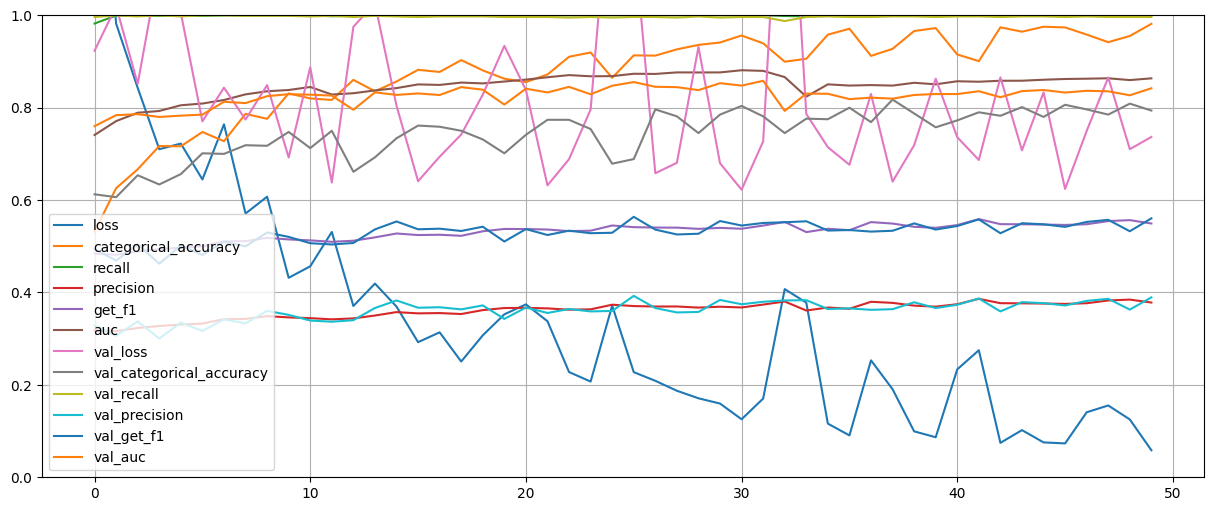

In [ ]:
plt.rcParams['figure.figsize']=(15,6)
pd.DataFrame(history.history).plot()
plt.grid()
plt.gca().set_ylim(0,1)
plt.savefig("Xception_without_Aug.png")
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test,axis=1),np.argmax(classifier.predict(x_test),axis=1)))

25/25 [==============================] - 2s 45ms/step
              precision    recall  f1-score   support

           0       0.86      0.60      0.71       105
           1       1.00      0.33      0.50         9
           2       0.89      0.80      0.84       403
           3       0.68      0.88      0.77       283

    accuracy                           0.79       800
   macro avg       0.86      0.65      0.70       800
weighted avg       0.81      0.79      0.79       800



In [ ]:
print(np.std(history.history['val_categorical_accuracy']))
print(np.std(history.history['val_recall']))
print(np.std(history.history['val_precision']))
print(np.std(history.history['val_get_f1']))
print(np.std(history.history['val_auc']))
print(np.mean(history.history['val_categorical_accuracy']))
print(np.mean(history.history['val_recall']))
print(np.mean(history.history['val_precision']))
print(np.mean(history.history['val_get_f1']))
print(np.mean(history.history['val_auc']))

0.052843168652981054
0.0018575854311664245
0.020825659224997878
0.02279515678156924
0.021410420017835503
0.7449249994754791
0.9969249880313873
0.36084620356559755
0.5299084889888763
0.8251332604885101


## Resnet152

In [ ]:
import tensorflow as tf

import keras.backend as K
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

model = tf.keras.applications.resnet.ResNet152(
    include_top=False,
    weights="imagenet",
    input_shape=(128,128,3)
)
model.trainable=False
output = keras.layers.Flatten()(model.output)
out = keras.layers.Dense(4,activation='sigmoid')(output)
classifier = keras.models.Model([model.input], [out])

classifier.compile(
    optimizer = tf.keras.optimizers.Adam(lr=0.001), 
    loss='categorical_crossentropy', 
    metrics=[keras.metrics.CategoricalAccuracy(), keras.metrics.Recall(), keras.metrics.Precision(), get_f1, keras.metrics.AUC()]
  )

history = classifier.fit(
    x_train,y_train,
    epochs=50,
    validation_data= (x_test,y_test),
    batch_size=32)

Epoch 1/50
175/175 [==============================] - 46s 149ms/step - loss: 1.0039 - categorical_accuracy: 0.5211 - recall: 0.9388 - precision: 0.3738 - get_f1: 0.5369 - auc: 0.8036 - val_loss: 0.9860 - val_categorical_accuracy: 0.4938 - val_recall: 0.9887 - val_precision: 0.3457 - val_get_f1: 0.5124 - val_auc: 0.8060
Epoch 2/50
175/175 [==============================] - 16s 92ms/step - loss: 0.9523 - categorical_accuracy: 0.5500 - recall: 0.9455 - precision: 0.3860 - get_f1: 0.5500 - auc: 0.8222 - val_loss: 0.9582 - val_categorical_accuracy: 0.5013 - val_recall: 0.8988 - val_precision: 0.4142 - val_get_f1: 0.5673 - val_auc: 0.8272
Epoch 3/50
175/175 [==============================] - 16s 89ms/step - loss: 0.9010 - categorical_accuracy: 0.5768 - recall: 0.9602 - precision: 0.3911 - get_f1: 0.5566 - auc: 0.8403 - val_loss: 0.8992 - val_categorical_accuracy: 0.5888 - val_recall: 0.9275 - val_precision: 0.4070 - val_get_f1: 0.5661 - val_auc: 0.8407
Epoch 4/50
175/175 [===================

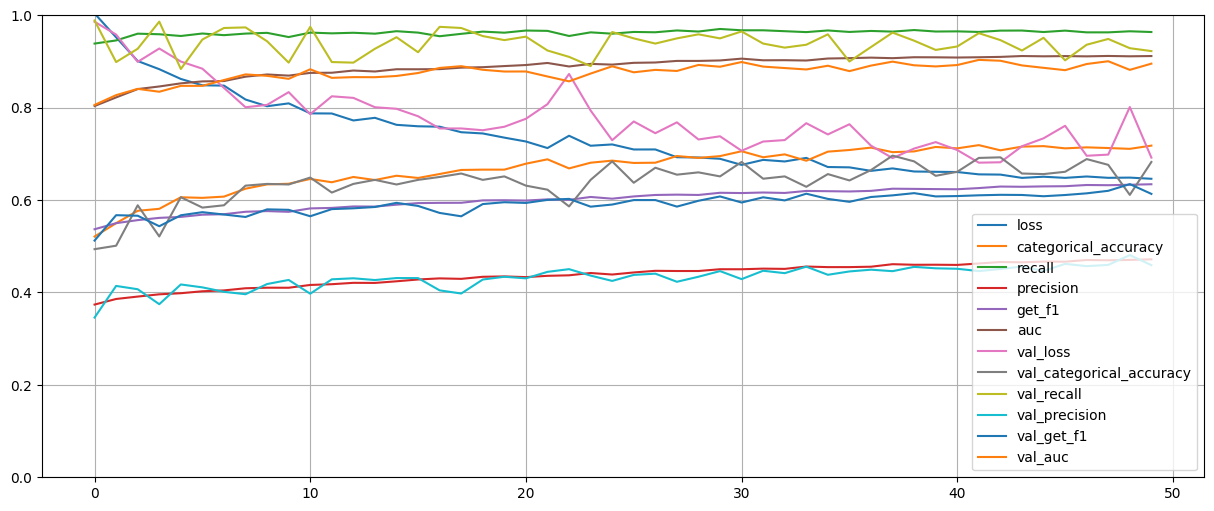

In [ ]:
plt.rcParams['figure.figsize']=(15,6)
pd.DataFrame(history.history).plot()
plt.grid()
plt.gca().set_ylim(0,1)
plt.savefig("Resnet152_without_Aug.png")
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_test,axis=1),np.argmax(classifier.predict(x_test),axis=1)))

25/25 [==============================] - 6s 78ms/step
              precision    recall  f1-score   support

           0       0.73      0.23      0.35       129
           1       0.67      1.00      0.80         6
           2       0.72      0.81      0.76       375
           3       0.62      0.71      0.66       290

    accuracy                           0.68       800
   macro avg       0.69      0.69      0.65       800
weighted avg       0.69      0.68      0.66       800



In [ ]:
print(np.std(history.history['val_categorical_accuracy']))
print(np.std(history.history['val_recall']))
print(np.std(history.history['val_precision']))
print(np.std(history.history['val_get_f1']))
print(np.std(history.history['val_auc']))
print(np.mean(history.history['val_categorical_accuracy']))
print(np.mean(history.history['val_recall']))
print(np.mean(history.history['val_precision']))
print(np.mean(history.history['val_get_f1']))
print(np.mean(history.history['val_auc']))

0.04333433802380532
0.025709922510854643
0.023930668682266367
0.02154606027468651
0.019969815701396287
0.6386500042676926
0.9395000004768371
0.43246582210063933
0.5919969499111175
0.8767441189289094
